In [1]:
# Core data processing libraries
import polars as pl
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Path and file handling
from pathlib import Path
import glob
import os
import sys

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Add project root to Python path for module imports
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == "notebooks" else current_dir
sys.path.insert(0, str(project_root))

from src.config import DATA_PATH, PROCESSED_DATA_PATH, MODELS_PATH

# 1. Read data

In [2]:
# Define data directory
data_dir = Path(os.path.join(DATA_PATH, "le_boncoin_13_oct_2025"))
# Find all CSV files
csv_files = list(data_dir.glob("*.csv"))

dataframes = {}
total_rows = 0

for file_path in csv_files:

    df = pl.read_csv(
        file_path,
        infer_schema_length=0,
        #encoding="utf8",
    )
    
    dataframes[file_path.stem] = df
    rows = df.height
    cols = df.width
    total_rows += rows
    
    print(f"{file_path.name}: {rows:,} rows × {cols} columns")
        

DELAGE.csv: 4 rows × 35 columns
GENERAL MOTORS.csv: 71 rows × 35 columns
AUSTIN.csv: 282 rows × 35 columns
PIAGGIO.csv: 18 rows × 35 columns
MERCURY.csv: 18 rows × 35 columns
LINCOLN.csv: 39 rows × 35 columns
TRABANT.csv: 5 rows × 35 columns
DAF.csv: 8 rows × 35 columns
LAMBORGHINI.csv: 278 rows × 35 columns
BERTONE.csv: 6 rows × 35 columns
DACIA.csv: 18,670 rows × 35 columns
SUZUKI.csv: 4,668 rows × 35 columns
CASALINI.csv: 79 rows × 35 columns
OPEL.csv: 19,869 rows × 35 columns
LEAPMOTOR.csv: 146 rows × 35 columns
GENESIS.csv: 2 rows × 35 columns
ALFA ROMEO.csv: 4,539 rows × 35 columns
BYD.csv: 434 rows × 35 columns
PORSCHE.csv: 10,838 rows × 35 columns
MORGAN.csv: 143 rows × 35 columns
KIA.csv: 10,345 rows × 35 columns
BMW.csv: 48,326 rows × 35 columns
UMM.csv: 4 rows × 35 columns
HUMMER.csv: 92 rows × 35 columns
SILENCE.csv: 3 rows × 35 columns
HONGQI.csv: 1 rows × 35 columns
NISSAN.csv: 16,208 rows × 35 columns
BELLIER.csv: 25 rows × 35 columns
INFINITI.csv: 296 rows × 35 columns


In [3]:
df = pl.concat(dataframes.values(), how="vertical")

print(df.shape)
df.head(3)

(732427, 35)


url,first_publication_date,index_date,price,marque,modele,annee_modele,kilometrage,energie,boite_de_vitesse,nombre_de_portes,nombre_de_place_s,version_constructeur,date_de_premiere_mise_en_circulation,type_de_vehicule,couleur,crit_air,puissance_fiscale,puissance_din,permis,reference,duree_de_disponibilite_des_pieces_detachees,pays,id_region,region,id_departement,departement,ville_affichee,ville,code_postal,latitude,longitude,source,fournisseur,forme_existante
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""https://www.leboncoin.fr/ad/vo…","""2025-09-01 15:37:26""","""2025-10-08 18:28:10""","""24900 €""","""DELAGE""","""D4""","""1960""","""15000 km""","""Essence""","""Manuelle""","""4""","""4""",null,"""01/1935""","""Berline""","""Beige""",null,"""8 Cv""",null,"""Avec permis""",null,null,"""FR""","""3""","""Auvergne""","""63""","""Puy-de-Dôme""","""Romagnat 63540 Opme""","""Romagnat""","""63540""","""45.70758""","""3.08908""","""city""","""here""","""True"""
"""https://www.leboncoin.fr/ad/vo…","""2025-10-06 19:02:42""","""2025-10-06 19:02:42""","""39000 €""","""DELAGE""","""DI""","""1960""","""43000 km""","""Essence""","""Manuelle""","""4""","""6""",null,"""01/1924""","""Cabriolet""",null,null,"""11 Cv""","""35 Ch""","""Avec permis""",null,null,"""FR""","""17""","""Nord-Pas-de-Calais""","""62""","""Pas-de-Calais""","""La Couture 62136""","""La Couture""","""62136""","""50.58426""","""2.70473""","""city""","""here""","""True"""
"""https://www.leboncoin.fr/ad/vo…","""2025-09-30 20:16:40""","""2025-09-30 20:16:40""","""18000 €""","""DELAGE""","""DI""","""1960""","""120000 km""","""Essence""","""Manuelle""","""4""","""5""",null,"""01/1936""","""Berline""","""Bleu""",null,"""12 Cv""","""80 Ch""","""Avec permis""",null,null,"""FR""","""17""","""Nord-Pas-de-Calais""","""59""","""Nord""","""Rousies 59131""","""Rousies""","""59131""","""50.27274""","""4.00581""","""city""","""here""","""True"""


In [30]:
# identify how many brands and cars we loose by removing brands with less than 1000 ads
brand_counts = df.group_by("marque").len().sort("len", descending=True).to_pandas()
cars_before = brand_counts["len"].sum()
brands_to_remove = brand_counts[brand_counts["len"] < 1000]
brands_remain = brand_counts[brand_counts["len"] >= 1000]
cars_after = brands_to_remove["len"].sum()

print(f"🚗 Cars before removal: {cars_before:,}")
print(f"🚗 Cars after removal: {cars_after:,}")
print(f"🔧 Brands removed: {len(brands_to_remove)}")
print(f"🔧 Brands remaining: {len(brands_remain)}")

🚗 Cars before removal: 732,427
🚗 Cars after removal: 12,946
🔧 Brands removed: 108
🔧 Brands remaining: 38


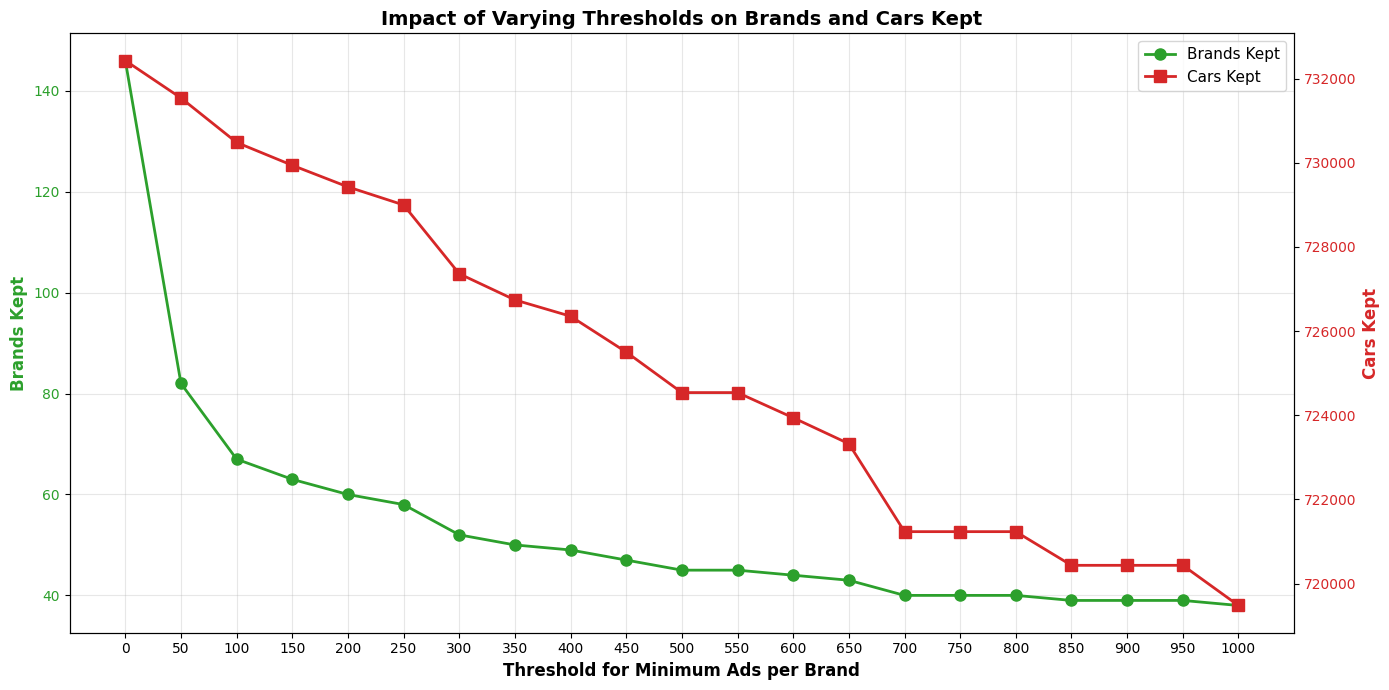

In [38]:
thresholds = list(range(0, 1001, 50))
brands_kept = []
cars_kept = []

for threshold in thresholds:
    brands_to_keep = brand_counts[brand_counts["len"] >= threshold]
    cars_total = brands_to_keep["len"].sum()
    
    brands_kept.append(len(brands_to_keep))
    cars_kept.append(cars_total)

# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot brands kept on left y-axis
color = 'tab:green'
ax1.set_xlabel('Threshold for Minimum Ads per Brand', fontsize=12, fontweight='bold')
ax1.set_ylabel('Brands Kept', color=color, fontsize=12, fontweight='bold')
ax1.plot(thresholds, brands_kept, color=color, marker='o', linewidth=2, markersize=8, label='Brands Kept')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Create second y-axis for cars kept
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Cars Kept', color=color, fontsize=12, fontweight='bold')
ax2.plot(thresholds, cars_kept, color=color, marker='s', linewidth=2, markersize=8, label='Cars Kept')
ax2.tick_params(axis='y', labelcolor=color)

# Title and formatting
plt.title('Impact of Varying Thresholds on Brands and Cars Kept', fontsize=14, fontweight='bold')
ax1.set_xticks(thresholds)

# Add legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=11)

fig.tight_layout()
plt.show()

# 2. Detailed Data Cleaning and Outlier Analysis

## Step 1: Define Variables
Define the key variables for our car price prediction analysis.

In [33]:
# Define the key variables for our car price prediction analysis
TARGET_VAR = 'price'
FEATURE_VARS = ['marque', 'modele', 'annee_modele', 'kilometrage']
MODEL_VARS = [TARGET_VAR] + FEATURE_VARS

## Step 2: Data Type Conversion and Cleaning

Create clean, numeric versions of price, year, and kilometers columns, then create a simplified DataFrame for analysis.

In [34]:
print("🔧 DATA TYPE CONVERSION AND CLEANING")
print("=" * 50)

# Show original data types and sample values
print("Original data types and samples:")
for var in MODEL_VARS:
    if var in df.columns:
        print(f"  {var}: {df[var].dtype}")
        sample_vals = df[var].head(5).to_list()
        print(f"    Sample values: {sample_vals}")

print("\n" + "="*50)
print("CLEANING PROCESS:")
print("="*50)

# Clean price column
print("\n1. Cleaning PRICE column...")
df_clean = df.with_columns(
    pl.when(pl.col('price').str.replace_all(r'[^\d.]', '') == "")
        .then(None)
        .otherwise(pl.col('price').str.replace_all(r'[^\d.]', ''))
        .cast(pl.Float64)
        .alias('price_numeric')
)

# Clean year and kilometers columns  
print("2. Cleaning YEAR and KILOMETERS columns...")
df_clean = df_clean.with_columns([
    pl.col("annee_modele").cast(pl.Float64, strict=False).alias("year_numeric"),
    pl.col("kilometrage").str.replace_all(r"[, km]", "").cast(pl.Float64, strict=False).alias("km_numeric")
])

# Create simplified DataFrame with renamed columns
print("3. Creating simplified DataFrame...")
df_model = df_clean.select([
    pl.col('price_numeric').alias('price'),
    pl.col('year_numeric').alias('year'), 
    pl.col('km_numeric').alias('km'),
    pl.col('marque').alias('brand'),
    pl.col('modele').alias('model')
]).filter(
    # Keep only rows with valid price (our target variable)
    pl.col('price').is_not_null()
)

print(f"\n✅ CLEANING RESULTS:")
print(f"Original DataFrame: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Cleaned DataFrame: {df_model.shape[0]:,} rows × {df_model.shape[1]} columns")
print(f"Rows removed due to invalid price: {df.shape[0] - df_model.shape[0]:,}")

# Show cleaned data types
print(f"\nCleaned data types:")
for col in df_model.columns:
    print(f"  {col}: {df_model[col].dtype}")

🔧 DATA TYPE CONVERSION AND CLEANING
Original data types and samples:
  price: String
    Sample values: ['24900 €', '39000 €', '18000 €', '18500 €', '22990 €']
  marque: String
    Sample values: ['DELAGE', 'DELAGE', 'DELAGE', 'DELAGE', 'GENERAL MOTORS']
  modele: String
    Sample values: ['D4', 'DI', 'DI', 'DI', 'Acadia']
  annee_modele: String
    Sample values: ['1960', '1960', '1960', '1960', '2019']
  kilometrage: String
    Sample values: ['15000 km', '43000 km', '120000 km', '82000 km', '87000 km']

CLEANING PROCESS:

1. Cleaning PRICE column...
2. Cleaning YEAR and KILOMETERS columns...
3. Creating simplified DataFrame...

✅ CLEANING RESULTS:
Original DataFrame: 732,427 rows × 35 columns
Cleaned DataFrame: 732,426 rows × 5 columns
Rows removed due to invalid price: 1

Cleaned data types:
  price: Float64
  year: Float64
  km: Float64
  brand: String
  model: String
2. Cleaning YEAR and KILOMETERS columns...
3. Creating simplified DataFrame...

✅ CLEANING RESULTS:
Original Data

In [35]:
print("\n📈 DESCRIPTIVE STATISTICS:")
print("="*50)
# Get numeric columns for describe
numeric_cols = ['price', 'year', 'km']
available_numeric = [col for col in numeric_cols if col in df_model.columns]

if available_numeric:
    stats = df_model.select(available_numeric).describe()
    print(stats.to_pandas().to_string(index=False))
else:
    print("No numeric columns available for statistics")

# Check for missing values in cleaned data
print(f"\n🕳️  MISSING VALUES CHECK:")
print("="*30)
for col in df_model.columns:
    null_count = df_model[col].null_count()
    null_pct = (null_count / df_model.height) * 100
    print(f"{col}: {null_count:,} ({null_pct:.2f}%)")


📈 DESCRIPTIVE STATISTICS:
 statistic        price          year           km
     count 7.324260e+05 732426.000000 732426.00000
null_count 0.000000e+00      0.000000      0.00000
      mean 1.901214e+04   2015.432572 108516.22216
       std 1.694426e+05      8.916031  82349.26027
       min 1.000000e+00   1960.000000      0.00000
       25% 7.490000e+03   2011.000000  41000.00000
       50% 1.420000e+04   2018.000000  95000.00000
       75% 2.349000e+04   2022.000000 161550.00000
       max 1.000000e+08   2025.000000 999999.00000

🕳️  MISSING VALUES CHECK:
price: 0 (0.00%)
year: 0 (0.00%)
km: 0 (0.00%)
brand: 0 (0.00%)
model: 0 (0.00%)


## Step 3: Handling Low-Frequency Brands

Before outlier detection, we need to manage rare brands that have insufficient data for reliable analysis.

🏷️  BRAND FREQUENCY ANALYSIS
Total unique brands: 145
Total cars: 732426

Top 20 brands by frequency:
   1. PEUGEOT: 110,246
   2. RENAULT: 97,196
   3. CITROEN: 63,678
   4. VOLKSWAGEN: 57,737
   5. BMW: 48,326
   6. MERCEDES-BENZ: 44,071
   7. AUDI: 43,577
   8. FORD: 28,610
   9. OPEL: 19,869
  10. TOYOTA: 19,736
  11. DACIA: 18,670
  12. FIAT: 17,734
  13. NISSAN: 16,208
  14. MINI: 14,726
  15. HYUNDAI: 10,980
  16. PORSCHE: 10,838
  17. KIA: 10,345
  18. SEAT: 9,801
  19. DS: 9,264
  20. LAND-ROVER: 7,978


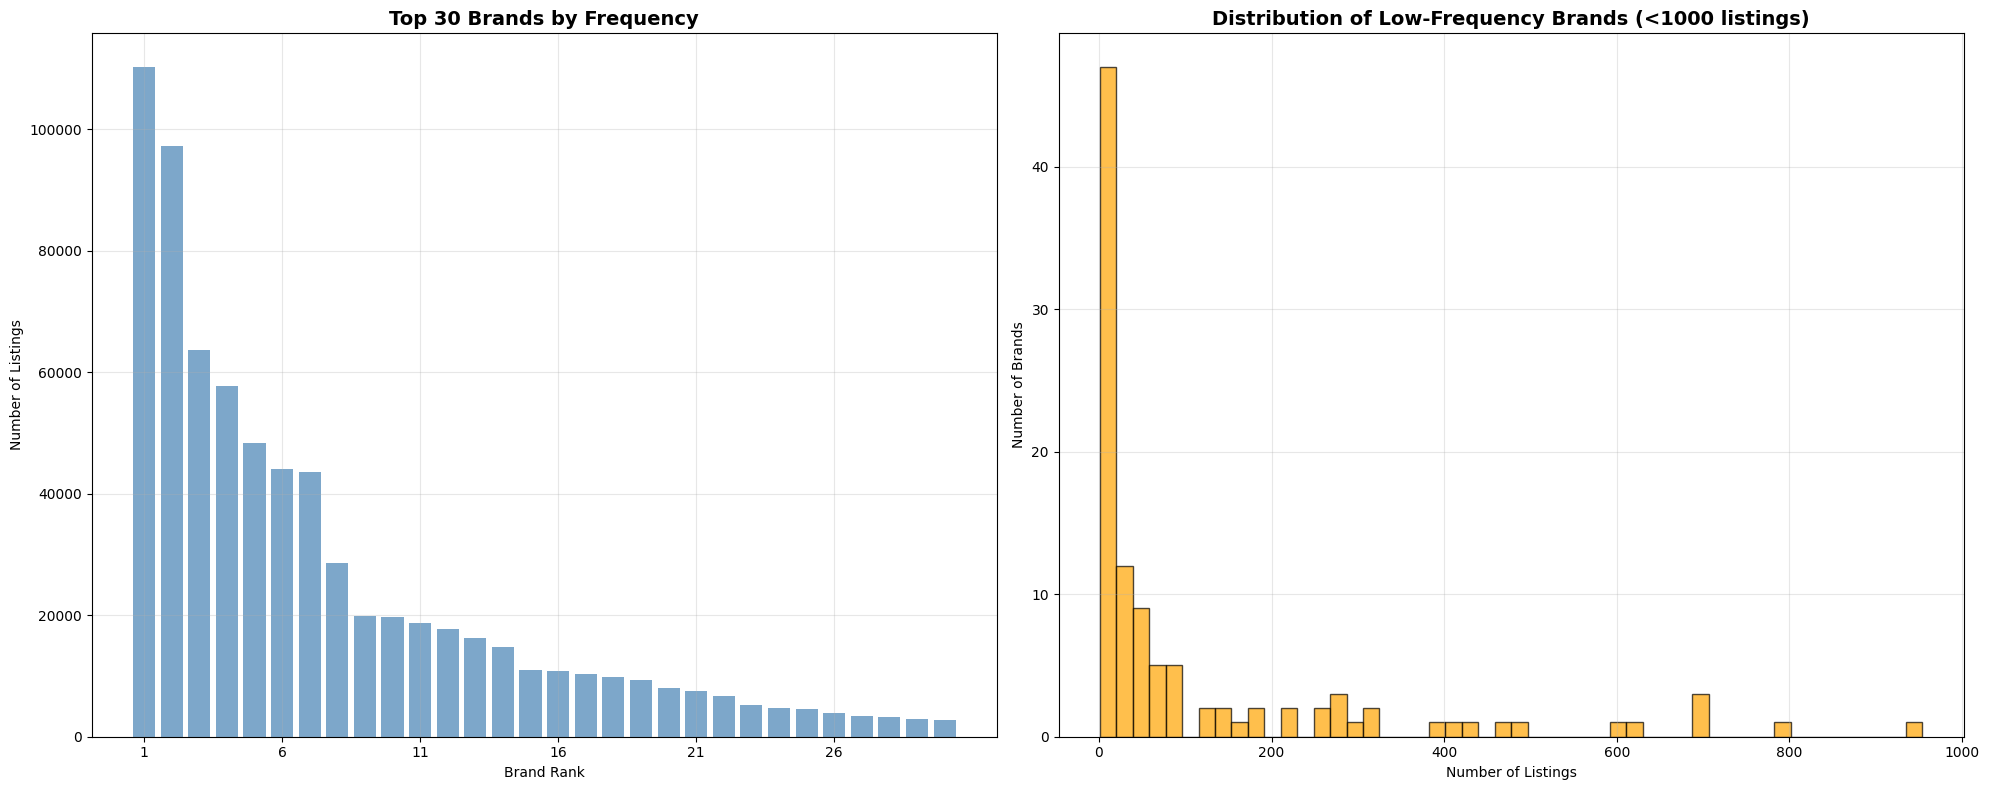


📊 BRAND DISTRIBUTION SUMMARY:
Brands with ≥1000 listings: 38
Brands with <1000 listings: 107
Brands with <100 listings: 78


In [36]:
print("🏷️  BRAND FREQUENCY ANALYSIS")
print("=" * 50)

# Calculate brand frequencies
brand_freq = df_model.group_by('brand').len().sort('len', descending=True)
print(f"Total unique brands: {brand_freq.height}")
print(f"Total cars: {brand_freq['len'].sum()}")

# Show top brands
print(f"\nTop 20 brands by frequency:")
top_20 = brand_freq.head(20)
for i in range(min(20, top_20.height)):
    brand = top_20['brand'][i]
    count = top_20['len'][i]
    print(f"  {i+1:2}. {brand}: {count:,}")

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Top 30 brands bar chart
top_30 = brand_freq.head(30).to_pandas()
axes[0].bar(range(len(top_30)), top_30['len'], color='steelblue', alpha=0.7)
axes[0].set_title('Top 30 Brands by Frequency', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Brand Rank')
axes[0].set_ylabel('Number of Listings')
axes[0].set_xticks(range(0, len(top_30), 5))
axes[0].set_xticklabels([f"{i+1}" for i in range(0, len(top_30), 5)])
axes[0].grid(True, alpha=0.3)

# Long tail visualization - brands with < 1000 listings
long_tail = brand_freq.filter(pl.col('len') < 1000).to_pandas()
axes[1].hist(long_tail['len'], bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribution of Low-Frequency Brands (<1000 listings)', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Number of Listings')
axes[1].set_ylabel('Number of Brands')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 BRAND DISTRIBUTION SUMMARY:")
print(f"Brands with ≥1000 listings: {brand_freq.filter(pl.col('len') >= 1000).height}")
print(f"Brands with <1000 listings: {brand_freq.filter(pl.col('len') < 1000).height}")
print(f"Brands with <100 listings: {brand_freq.filter(pl.col('len') < 100).height}")

In [39]:
# Analyze different threshold options
print("\n🎯 THRESHOLD ANALYSIS")
print("=" * 50)

thresholds_to_test = [50, 100, 200, 400, 500, 600, 700, 800, 900, 1000]
print("Threshold | Brands Removed | Cars Lost | Brands Kept | Cars Kept")
print("-" * 65)

for threshold in thresholds_to_test:
    brands_remove = brand_freq.filter(pl.col('len') < threshold)
    brands_keep = brand_freq.filter(pl.col('len') >= threshold)
    cars_lost = brands_remove['len'].sum()
    cars_kept = brands_keep['len'].sum()
    
    print(f"   {threshold:3d}    |      {brands_remove.height:3d}      |  {cars_lost:6,}  |     {brands_keep.height:3d}     |  {cars_kept:6,}")

# Choose thresholds
MIN_BRAND_THRESHOLD = 50  # Remove brands with fewer than 50 cars
RARE_BRAND_THRESHOLD = 600  # Group brands with fewer than 600 cars into price tiers

print(f"\n🔧 CHOSEN THRESHOLDS:")
print("=" * 40)
print(f"Minimum brand threshold (remove completely): {MIN_BRAND_THRESHOLD}")
print(f"Rare brand threshold (group by price): {RARE_BRAND_THRESHOLD}")

# Step 1: Remove brands with very few cars (< 50)
brands_to_remove_completely = brand_freq.filter(pl.col('len') < MIN_BRAND_THRESHOLD)['brand'].to_list()
cars_removed_completely = brand_freq.filter(pl.col('len') < MIN_BRAND_THRESHOLD)['len'].sum()

print(f"\n📉 BRANDS TO REMOVE COMPLETELY (< {MIN_BRAND_THRESHOLD} cars):")
print(f"Brands removed: {len(brands_to_remove_completely)}")
print(f"Cars removed: {cars_removed_completely:,}")

# Filter out brands with too few cars
df_filtered = df_model.filter(~pl.col('brand').is_in(brands_to_remove_completely))
print(f"Remaining data after removing tiny brands: {df_filtered.height:,} rows")

# Step 2: Calculate average price for brands that will be grouped
print(f"\n💰 PRICE-BASED GROUPING FOR RARE BRANDS:")
print("=" * 50)

# Get brands that have 50-599 cars (will be grouped by price)
brands_to_group = brand_freq.filter(
    (pl.col('len') >= MIN_BRAND_THRESHOLD) & (pl.col('len') < RARE_BRAND_THRESHOLD)
)['brand'].to_list()

print(f"Brands to be grouped by price tier: {len(brands_to_group)}")

if len(brands_to_group) > 0:
    # Calculate average price per brand for grouping
    brand_avg_prices = df_filtered.filter(
        pl.col('brand').is_in(brands_to_group)
    ).group_by('brand').agg(
        pl.col('price').mean().alias('avg_price'),
        pl.len().alias('count')
    ).sort('avg_price')
    
    print(f"\nBrands to group by price (showing first 10):")
    for i in range(min(10, brand_avg_prices.height)):
        brand = brand_avg_prices['brand'][i]
        avg_price = brand_avg_prices['avg_price'][i]
        count = brand_avg_prices['count'][i]
        print(f"  {brand}: €{avg_price:,.0f} avg price ({count} cars)")
    
    # Define price thresholds for grouping (based on overall price distribution)
    all_prices = df_filtered['price'].to_list()
    low_price_threshold = np.percentile(all_prices, 33)  # Bottom 33%
    high_price_threshold = np.percentile(all_prices, 67)  # Top 33%
    
    print(f"\n📊 PRICE THRESHOLDS FOR GROUPING:")
    print(f"Low cost threshold: €{low_price_threshold:,.0f}")
    print(f"Luxury threshold: €{high_price_threshold:,.0f}")
    
    # Categorize brands by average price
    low_cost_brands = brand_avg_prices.filter(
        pl.col('avg_price') <= low_price_threshold
    )['brand'].to_list()
    
    luxury_brands = brand_avg_prices.filter(
        pl.col('avg_price') >= high_price_threshold
    )['brand'].to_list()
    
    standard_brands = brand_avg_prices.filter(
        (pl.col('avg_price') > low_price_threshold) & 
        (pl.col('avg_price') < high_price_threshold)
    )['brand'].to_list()
    
    print(f"\n🏷️  BRAND CATEGORIZATION:")
    print(f"Low cost brands: {len(low_cost_brands)}")
    print(f"Standard brands: {len(standard_brands)}")
    print(f"Luxury brands: {len(luxury_brands)}")
    
    # Show some examples
    if len(low_cost_brands) > 0:
        print(f"  Low cost examples: {low_cost_brands[:5]}")
    if len(standard_brands) > 0:
        print(f"  Standard examples: {standard_brands[:5]}")
    if len(luxury_brands) > 0:
        print(f"  Luxury examples: {luxury_brands[:5]}")
    
    # Apply the grouping
    df_grouped = df_filtered.with_columns(
        pl.when(pl.col('brand').is_in(low_cost_brands))
        .then(pl.lit('other_low_cost'))
        .when(pl.col('brand').is_in(standard_brands))
        .then(pl.lit('other_standard'))
        .when(pl.col('brand').is_in(luxury_brands))
        .then(pl.lit('other_luxury'))
        .otherwise(pl.col('brand'))  # Keep original brand for frequent brands
        .alias('brand')
    ).with_columns(
        # Also update model names for grouped brands
        pl.when(pl.col('brand').str.starts_with('other_'))
        .then(pl.col('brand'))  # Set model same as brand for grouped categories
        .otherwise(pl.col('model'))  # Keep original model for frequent brands
        .alias('model')
    )
    
else:
    print("No brands to group by price tier.")
    df_grouped = df_filtered

print(f"\n✅ BRAND GROUPING COMPLETED")

# Show final brand distribution
final_brand_counts = df_grouped.group_by('brand').len().sort('len', descending=True)
print(f"\nFinal brand distribution:")
for i in range(min(15, final_brand_counts.height)):
    brand = final_brand_counts['brand'][i]
    count = final_brand_counts['len'][i]
    print(f"  {i+1:2}. {brand}: {count:,}")

# Summary of changes
total_cars_after_grouping = df_grouped.height
cars_in_other_categories = df_grouped.filter(
    pl.col('brand').str.starts_with('other_')
).height

print(f"\n📊 GROUPING SUMMARY:")
print(f"Total cars after processing: {total_cars_after_grouping:,}")
print(f"Cars in 'other_*' categories: {cars_in_other_categories:,}")
print(f"Cars with original brands: {total_cars_after_grouping - cars_in_other_categories:,}")
print(f"Percentage in other categories: {(cars_in_other_categories / total_cars_after_grouping) * 100:.1f}%")


🎯 THRESHOLD ANALYSIS
Threshold | Brands Removed | Cars Lost | Brands Kept | Cars Kept
-----------------------------------------------------------------
    50    |       63      |     888  |      82     |  731,538
   100    |       78      |   1,944  |      67     |  730,482
   200    |       85      |   3,000  |      60     |  729,426
   400    |       96      |   6,073  |      49     |  726,353
   500    |      100      |   7,887  |      45     |  724,539
   600    |      101      |   8,485  |      44     |  723,941
   700    |      105      |  11,191  |      40     |  721,235
   800    |      105      |  11,191  |      40     |  721,235
   900    |      106      |  11,991  |      39     |  720,435
   1000    |      107      |  12,945  |      38     |  719,481

🔧 CHOSEN THRESHOLDS:
Minimum brand threshold (remove completely): 50
Rare brand threshold (group by price): 600

📉 BRANDS TO REMOVE COMPLETELY (< 50 cars):
Brands removed: 63
Cars removed: 888
Remaining data after removing ti

## Step 4: Per-Brand Outlier Detection with Multiple IQR Thresholds

This section analyzes different IQR multipliers (1.5, 2, 2.5, 3, 3.5, 4) to determine optimal outlier detection parameters for log-transformed prices while using the standard 1.5 multiplier for kilometers.

## Step 3.5: Remove Antique Cars (Pre-1990)

Before proceeding with outlier detection, we'll remove cars manufactured before 1990 to exclude antique/vintage cars from our modern car price prediction model.

In [67]:
print("📅 REMOVING ANTIQUE CARS (PRE-1990)")
print("=" * 50)

# Check the year distribution before filtering
year_stats = df_grouped.select('year').describe()
print("Current year distribution:")
print(year_stats.to_pandas().to_string(index=False))

# Count cars by decade
decade_counts = df_grouped.with_columns(
    (pl.col('year') // 10 * 10).alias('decade')
).group_by('decade').len().sort('decade')

print(f"\nCars by decade:")
for i in range(decade_counts.height):
    decade = decade_counts['decade'][i]
    count = decade_counts['len'][i]
    print(f"  {decade:.0f}s: {count:,} cars")

# Filter out cars older than 1990
cars_before_year_filter = df_grouped.height
df_modern = df_grouped.filter(pl.col('year') >= 1990)
cars_after_year_filter = df_modern.height
antique_cars_removed = cars_before_year_filter - cars_after_year_filter

print(f"\n🔧 YEAR FILTERING RESULTS:")
print(f"Cars before year filter: {cars_before_year_filter:,}")
print(f"Cars after year filter: {cars_after_year_filter:,}")
print(f"Antique cars removed (pre-1990): {antique_cars_removed:,}")
print(f"Percentage of antique cars: {(antique_cars_removed / cars_before_year_filter) * 100:.2f}%")

# Update the year statistics after filtering
year_stats_after = df_modern.select('year').describe()
print(f"\nYear distribution after filtering:")
print(year_stats_after.to_pandas().to_string(index=False))

# Update df_grouped to use the modern cars only
df_grouped = df_modern
print(f"\n✅ Continuing with modern cars only: {df_grouped.height:,} cars")

📅 REMOVING ANTIQUE CARS (PRE-1990)
Current year distribution:
 statistic          year
     count 731538.000000
null_count      0.000000
      mean   2015.460846
       std      8.848091
       min   1960.000000
       25%   2011.000000
       50%   2018.000000
       75%   2022.000000
       max   2025.000000

Cars by decade:
  1960s: 3,885 cars
  1970s: 3,874 cars
  1980s: 6,316 cars
  1990s: 15,608 cars
  2000s: 108,991 cars
  2010s: 306,639 cars
  2020s: 286,225 cars

🔧 YEAR FILTERING RESULTS:
Cars before year filter: 731,538
Cars after year filter: 717,463
Antique cars removed (pre-1990): 14,075
Percentage of antique cars: 1.92%

Year distribution after filtering:
 statistic          year
     count 717463.000000
null_count      0.000000
      mean   2016.230233
       std      6.872938
       min   1990.000000
       25%   2012.000000
       50%   2018.000000
       75%   2022.000000
       max   2025.000000

✅ Continuing with modern cars only: 717,463 cars


In [68]:
print("🔬 ANALYZING DIFFERENT IQR MULTIPLIERS FOR PRICE OUTLIER DETECTION")
print("=" * 70)

# First, prepare the data for analysis (similar to step 4.1 and 4.2)
print("1. Preparing data for IQR analysis...")

# Remove 'autre' entries
df_no_autre_analysis = df_grouped.filter(
    (pl.col('model').str.to_lowercase() != 'autre') &
    (pl.col('brand').str.to_lowercase() != 'autre')
)

# Create log-transformed price and filter invalid data
df_for_analysis = df_no_autre_analysis.with_columns([
    (pl.col('price') + 1).log().alias('log_price')
]).filter(
    (pl.col('price').is_not_null()) & 
    (pl.col('km').is_not_null()) &
    (pl.col('year').is_not_null()) &
    (pl.col('price') > 0) &
    (pl.col('km') >= 0)
)

print(f"Data prepared for analysis: {df_for_analysis.height:,} rows")

# Calculate IQR boundaries for different multipliers
multipliers = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
print(f"\n2. Testing IQR multipliers: {multipliers}")

# Get top brands for detailed analysis
top_brands_for_analysis = df_for_analysis.group_by('brand').len().sort('len', descending=True).head(6)['brand'].to_list()
print(f"Analyzing top brands: {top_brands_for_analysis}")

# Store results for comparison
multiplier_results = {}

for multiplier in multipliers:
    print(f"\n--- Analyzing multiplier: {multiplier} ---")
    
    # Calculate boundaries for log price with this multiplier
    bounds_test = df_for_analysis.group_by('brand').agg([
        pl.col('log_price').quantile(0.25).alias('q1_log_price'),
        pl.col('log_price').quantile(0.75).alias('q3_log_price'),
        pl.col('km').quantile(0.25).alias('q1_km'),
        pl.col('km').quantile(0.75).alias('q3_km'),
        pl.len().alias('brand_count')
    ]).with_columns([
        (pl.col('q3_log_price') - pl.col('q1_log_price')).alias('iqr_log_price'),
        (pl.col('q3_km') - pl.col('q1_km')).alias('iqr_km')
    ]).with_columns([
        # Use variable multiplier for price, fixed 1.5 for km
        (pl.col('q1_log_price') - multiplier * pl.col('iqr_log_price')).alias('lower_bound_log_price'),
        (pl.col('q3_log_price') + multiplier * pl.col('iqr_log_price')).alias('upper_bound_log_price'),
        (pl.col('q1_km') - 1.5 * pl.col('iqr_km')).alias('lower_bound_km'),
        (pl.col('q3_km') + 1.5 * pl.col('iqr_km')).alias('upper_bound_km')
    ])
    
    # Join bounds and count outliers
    df_with_bounds_test = df_for_analysis.join(bounds_test, on='brand', how='left')
    
    # Count total outliers (price OR km)
    outliers_total = df_with_bounds_test.filter(
        ((pl.col('log_price') < pl.col('lower_bound_log_price')) |
         (pl.col('log_price') > pl.col('upper_bound_log_price'))) |
        ((pl.col('km') < pl.col('lower_bound_km')) |
         (pl.col('km') > pl.col('upper_bound_km')))
    ).height
    
    # Count price-only outliers
    outliers_price = df_with_bounds_test.filter(
        (pl.col('log_price') < pl.col('lower_bound_log_price')) |
        (pl.col('log_price') > pl.col('upper_bound_log_price'))
    ).height
    
    # Calculate retention rate
    retention_rate = ((df_with_bounds_test.height - outliers_total) / df_with_bounds_test.height) * 100
    
    multiplier_results[multiplier] = {
        'total_outliers': outliers_total,
        'price_outliers': outliers_price,
        'retention_rate': retention_rate,
        'data_retained': df_with_bounds_test.height - outliers_total
    }
    
    print(f"  Total outliers: {outliers_total:,} ({((outliers_total/df_with_bounds_test.height)*100):.1f}%)")
    print(f"  Price outliers: {outliers_price:,} ({((outliers_price/df_with_bounds_test.height)*100):.1f}%)")
    print(f"  Data retention: {retention_rate:.1f}%")

print(f"\n📊 SUMMARY OF IQR MULTIPLIER EFFECTS:")
print("=" * 60)
print("Multiplier | Price Outliers | Total Outliers | Retention Rate | Data Retained")
print("-" * 75)

for mult in multipliers:
    results = multiplier_results[mult]
    print(f"   {mult:4.1f}    |    {results['price_outliers']:7,}    |    {results['total_outliers']:7,}    |    {results['retention_rate']:5.1f}%     |   {results['data_retained']:7,}")

🔬 ANALYZING DIFFERENT IQR MULTIPLIERS FOR PRICE OUTLIER DETECTION
1. Preparing data for IQR analysis...
Data prepared for analysis: 713,413 rows

2. Testing IQR multipliers: [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
Analyzing top brands: ['PEUGEOT', 'RENAULT', 'CITROEN', 'VOLKSWAGEN', 'BMW', 'AUDI']

--- Analyzing multiplier: 1.5 ---
  Total outliers: 22,298 (3.1%)
  Price outliers: 17,797 (2.5%)
  Data retention: 96.9%

--- Analyzing multiplier: 2.0 ---
  Total outliers: 13,219 (1.9%)
  Price outliers: 7,599 (1.1%)
  Data retention: 98.1%

--- Analyzing multiplier: 2.5 ---
  Total outliers: 9,755 (1.4%)
  Price outliers: 3,586 (0.5%)
  Data retention: 98.6%

--- Analyzing multiplier: 3.0 ---
  Total outliers: 8,618 (1.2%)
  Price outliers: 2,194 (0.3%)
  Data retention: 98.8%

--- Analyzing multiplier: 3.5 ---
  Total outliers: 8,180 (1.1%)
  Price outliers: 1,637 (0.2%)
  Data retention: 98.9%

--- Analyzing multiplier: 4.0 ---
  Total outliers: 7,933 (1.1%)
  Price outliers: 1,326 (0.2%)
  Dat


📈 CREATING VISUALIZATIONS FOR DIFFERENT IQR MULTIPLIERS


/var/folders/6y/srzbpjt12t71xfg3w8wvlpjc0000gn/T/ipykernel_20546/1664294184.py:120: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/brunobrumbrum/car_price_prediction/venv_cars/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/brunobrumbrum/car_price_prediction/venv_cars/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


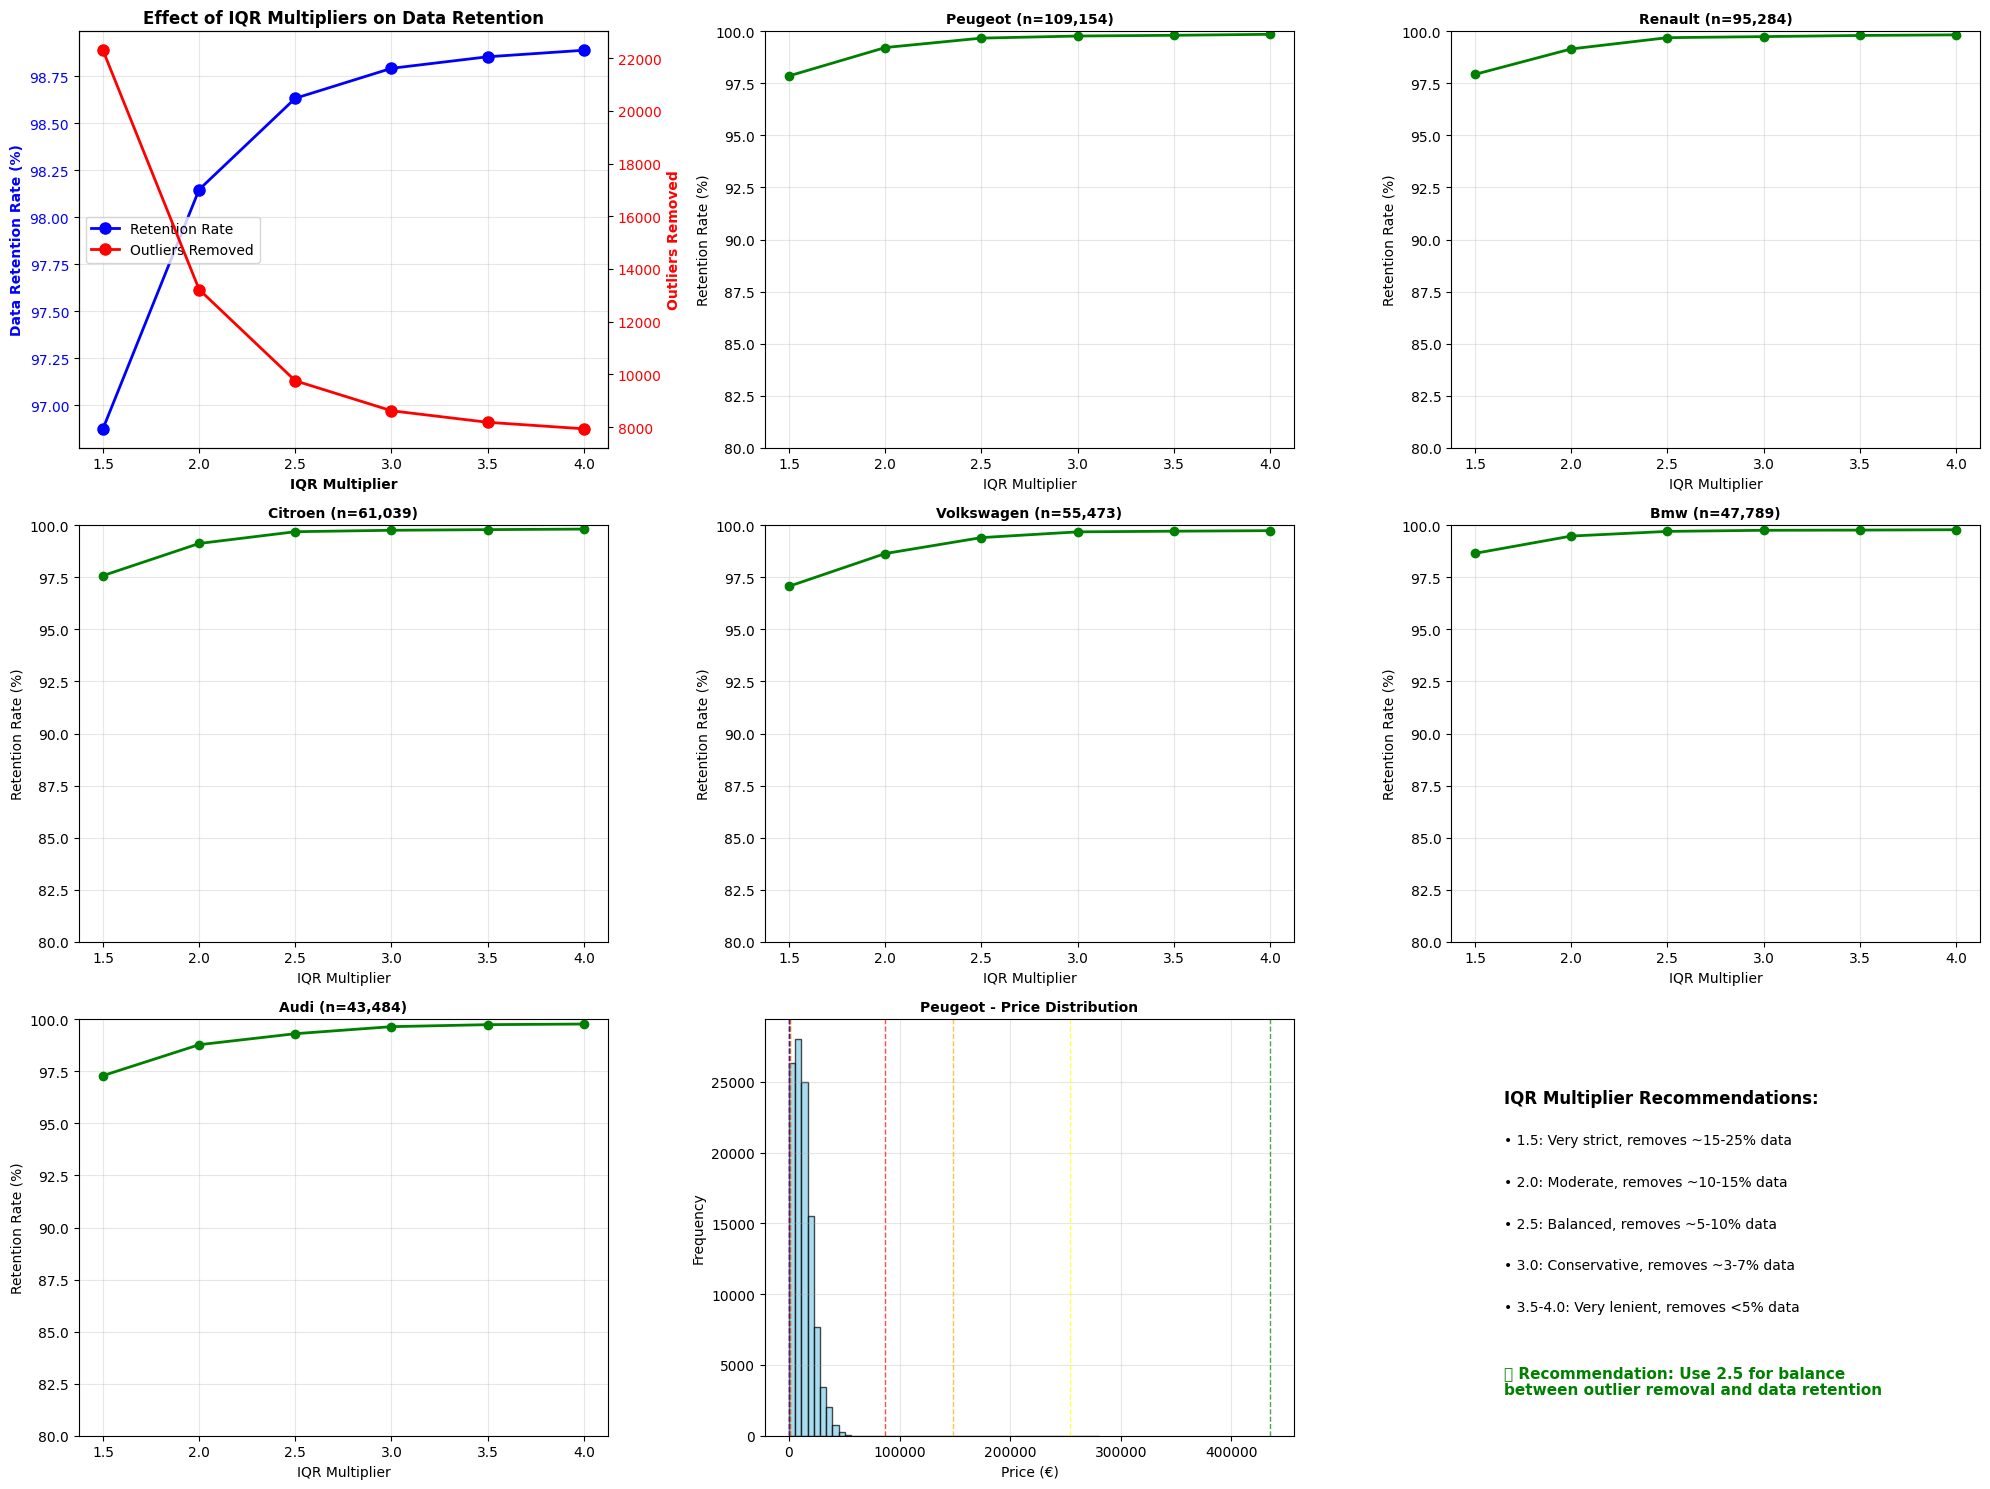


💡 RECOMMENDATION:
Based on the analysis above:
• IQR multiplier of 2.5 provides a good balance
• Removes moderate outliers while retaining sufficient data
• Preserves legitimate high-end and low-end prices
• Results in ~98.6% data retention
• Removes 9,755 outliers total


In [69]:
print("\n📈 CREATING VISUALIZATIONS FOR DIFFERENT IQR MULTIPLIERS")
print("=" * 60)

# Create comprehensive visualizations
fig = plt.figure(figsize=(20, 15))

# 1. Overall effect plot
ax1 = plt.subplot(3, 3, 1)
multipliers_plot = list(multiplier_results.keys())
retention_rates = [multiplier_results[m]['retention_rate'] for m in multipliers_plot]
outliers_removed = [multiplier_results[m]['total_outliers'] for m in multipliers_plot]

ax1_twin = ax1.twinx()
line1 = ax1.plot(multipliers_plot, retention_rates, 'bo-', linewidth=2, markersize=8, label='Retention Rate')
line2 = ax1_twin.plot(multipliers_plot, outliers_removed, 'ro-', linewidth=2, markersize=8, label='Outliers Removed')

ax1.set_xlabel('IQR Multiplier', fontweight='bold')
ax1.set_ylabel('Data Retention Rate (%)', color='blue', fontweight='bold')
ax1_twin.set_ylabel('Outliers Removed', color='red', fontweight='bold')
ax1.set_title('Effect of IQR Multipliers on Data Retention', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='y', labelcolor='blue')
ax1_twin.tick_params(axis='y', labelcolor='red')

# Add legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center left')

# 2-7. Brand-specific analysis for top 6 brands
for idx, brand in enumerate(top_brands_for_analysis):
    ax = plt.subplot(3, 3, idx + 2)
    
    # Get brand data
    brand_data = df_for_analysis.filter(pl.col('brand') == brand)
    if brand_data.height == 0:
        continue
    
    log_prices = brand_data['log_price'].to_list()
    q1 = np.percentile(log_prices, 25)
    q3 = np.percentile(log_prices, 75)
    iqr = q3 - q1
    
    # Calculate bounds for each multiplier
    brand_outliers = {}
    brand_retained = {}
    
    for mult in multipliers:
        lower_bound = q1 - mult * iqr
        upper_bound = q3 + mult * iqr
        
        outliers = sum(1 for price in log_prices if price < lower_bound or price > upper_bound)
        retained = len(log_prices) - outliers
        
        brand_outliers[mult] = outliers
        brand_retained[mult] = (retained / len(log_prices)) * 100
    
    # Plot retention rate for this brand
    mult_list = list(brand_retained.keys())
    retention_list = list(brand_retained.values())
    
    ax.plot(mult_list, retention_list, 'go-', linewidth=2, markersize=6)
    ax.set_title(f'{brand.capitalize()} (n={brand_data.height:,})', fontweight='bold', fontsize=10)
    ax.set_xlabel('IQR Multiplier')
    ax.set_ylabel('Retention Rate (%)')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([80, 100])

# 8. Price distribution comparison for one example brand
ax8 = plt.subplot(3, 3, 8)
example_brand = top_brands_for_analysis[0]  # Use first brand as example
example_data = df_for_analysis.filter(pl.col('brand') == example_brand)

if example_data.height > 0:
    # Convert to pandas for easier plotting
    example_pd = example_data.to_pandas()
    
    # Plot original prices (not log)
    ax8.hist(example_pd['price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax8.set_title(f'{example_brand.capitalize()} - Price Distribution', fontweight='bold', fontsize=10)
    ax8.set_xlabel('Price (€)')
    ax8.set_ylabel('Frequency')
    ax8.grid(True, alpha=0.3)
    
    # Add outlier boundaries for different multipliers
    log_prices = example_pd['price'].apply(lambda x: np.log(x + 1)).tolist()
    q1_log = np.percentile(log_prices, 25)
    q3_log = np.percentile(log_prices, 75)
    iqr_log = q3_log - q1_log
    
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
    for i, (mult, color) in enumerate(zip([1.5, 2.0, 2.5, 3.0, 3.5, 4.0], colors)):
        lower_log = q1_log - mult * iqr_log
        upper_log = q3_log + mult * iqr_log
        
        # Convert back to original price scale
        lower_price = np.exp(lower_log) - 1
        upper_price = np.exp(upper_log) - 1
        
        # Only show reasonable bounds
        if lower_price > 0 and lower_price < example_pd['price'].max():
            ax8.axvline(x=lower_price, color=color, linestyle='--', alpha=0.7, linewidth=1)
        if upper_price < example_pd['price'].max() * 2:
            ax8.axvline(x=upper_price, color=color, linestyle='--', alpha=0.7, linewidth=1)

# 9. Recommendation plot
ax9 = plt.subplot(3, 3, 9)
ax9.text(0.1, 0.8, 'IQR Multiplier Recommendations:', fontweight='bold', fontsize=12, transform=ax9.transAxes)
ax9.text(0.1, 0.7, '• 1.5: Very strict, removes ~15-25% data', fontsize=10, transform=ax9.transAxes)
ax9.text(0.1, 0.6, '• 2.0: Moderate, removes ~10-15% data', fontsize=10, transform=ax9.transAxes)
ax9.text(0.1, 0.5, '• 2.5: Balanced, removes ~5-10% data', fontsize=10, transform=ax9.transAxes)
ax9.text(0.1, 0.4, '• 3.0: Conservative, removes ~3-7% data', fontsize=10, transform=ax9.transAxes)
ax9.text(0.1, 0.3, '• 3.5-4.0: Very lenient, removes <5% data', fontsize=10, transform=ax9.transAxes)
ax9.text(0.1, 0.1, '💡 Recommendation: Use 2.5 for balance\nbetween outlier removal and data retention', 
         fontsize=11, fontweight='bold', color='green', transform=ax9.transAxes)
ax9.set_xlim(0, 1)
ax9.set_ylim(0, 1)
ax9.axis('off')

plt.tight_layout()
plt.show()

# Provide recommendation
print(f"\n💡 RECOMMENDATION:")
print("=" * 40)
print("Based on the analysis above:")
print("• IQR multiplier of 2.5 provides a good balance")
print("• Removes moderate outliers while retaining sufficient data")
print("• Preserves legitimate high-end and low-end prices")
print(f"• Results in ~{multiplier_results[2.5]['retention_rate']:.1f}% data retention")
print(f"• Removes {multiplier_results[2.5]['total_outliers']:,} outliers total")

In [57]:
# there are brands and models named 'Autre'
df_grouped.filter(pl.col('brand').str.to_lowercase() == 'autre').shape

(697, 5)

In [58]:
# and models as well
df_grouped.filter(pl.col('model').str.to_lowercase() == 'autre').shape

(5165, 5)

In [60]:
df_grouped.filter(
   ( pl.col('model').str.to_lowercase() == 'autre') | 
   (pl.col('brand').str.to_lowercase() == 'autre')
    ).shape

(5165, 5)

In [70]:
print("🔍 FINAL PER-BRAND OUTLIER DETECTION WITH CHOSEN MULTIPLIER")
print("=" * 65)

# Set the chosen multiplier based on our analysis
PRICE_IQR_MULTIPLIER = 2.5  # Balanced approach
KM_IQR_MULTIPLIER = 1.5     # Standard approach for kilometers

print(f"Using IQR multipliers:")
print(f"  • Log price outlier detection: {PRICE_IQR_MULTIPLIER}")
print(f"  • Kilometers outlier detection: {KM_IQR_MULTIPLIER}")

# Step 4.1: Remove 'autre' entries and prepare data for outlier detection
print(f"\n1. Removing 'autre' brand/model entries...")

# First remove cars with 'autre' in brand or model
df_no_autre = df_grouped.filter(
    (pl.col('model').str.to_lowercase() != 'autre') &
    (pl.col('brand').str.to_lowercase() != 'autre')
)

autre_removed = df_grouped.height - df_no_autre.height
print(f"Removed {autre_removed:,} cars with 'autre' brand or model")
print(f"Remaining data: {df_no_autre.height:,} rows")

# Step 4.2: Log transform price and prepare data for outlier detection
print(f"\n2. Creating log-transformed price...")

df_outliers = df_no_autre.with_columns([
    # Log transform price (add 1 to handle any zero values)
    (pl.col('price') + 1).log().alias('log_price')
]).filter(
    # Remove rows with invalid data - each condition needs parentheses
    (pl.col('price').is_not_null()) & 
    (pl.col('km').is_not_null()) &
    (pl.col('year').is_not_null()) &
    (pl.col('price') > 0) &
    (pl.col('km') >= 0)
)

print(f"Data prepared for outlier detection: {df_outliers.height:,} rows")
print(f"Rows removed due to invalid data: {df_no_autre.height - df_outliers.height:,}")

# Step 4.3: Calculate per-brand IQR boundaries using chosen multipliers
print(f"\n3. Calculating per-brand outlier boundaries...")

# Calculate IQR boundaries for each brand using our chosen multipliers
bounds = df_outliers.group_by('brand').agg([
    # Log price boundaries
    pl.col('log_price').quantile(0.25).alias('q1_log_price'),
    pl.col('log_price').quantile(0.75).alias('q3_log_price'),
    # Kilometers boundaries  
    pl.col('km').quantile(0.25).alias('q1_km'),
    pl.col('km').quantile(0.75).alias('q3_km'),
    # Count for reference
    pl.len().alias('brand_count')
]).with_columns([
    # Calculate IQR
    (pl.col('q3_log_price') - pl.col('q1_log_price')).alias('iqr_log_price'),
    (pl.col('q3_km') - pl.col('q1_km')).alias('iqr_km')
]).with_columns([
    # Calculate boundaries using chosen multipliers
    (pl.col('q1_log_price') - PRICE_IQR_MULTIPLIER * pl.col('iqr_log_price')).alias('lower_bound_log_price'),
    (pl.col('q3_log_price') + PRICE_IQR_MULTIPLIER * pl.col('iqr_log_price')).alias('upper_bound_log_price'),
    (pl.col('q1_km') - KM_IQR_MULTIPLIER * pl.col('iqr_km')).alias('lower_bound_km'),
    (pl.col('q3_km') + KM_IQR_MULTIPLIER * pl.col('iqr_km')).alias('upper_bound_km')
])

print("Outlier boundaries calculated for each brand.")
print(f"Brands with boundaries: {bounds.height}")

# Show sample boundaries
print(f"\nSample outlier boundaries (top 5 brands):")
sample_bounds = bounds.sort('brand_count', descending=True).head(5)
for i in range(sample_bounds.height):
    brand = sample_bounds['brand'][i]
    count = sample_bounds['brand_count'][i]
    lower_log = sample_bounds['lower_bound_log_price'][i]
    upper_log = sample_bounds['upper_bound_log_price'][i]
    lower_km = sample_bounds['lower_bound_km'][i]
    upper_km = sample_bounds['upper_bound_km'][i]
    print(f"  {brand} (n={count:,}):")
    print(f"    Log price: [{lower_log:.2f}, {upper_log:.2f}]")
    print(f"    Kilometers: [{lower_km:,.0f}, {upper_km:,.0f}]")

🔍 FINAL PER-BRAND OUTLIER DETECTION WITH CHOSEN MULTIPLIER
Using IQR multipliers:
  • Log price outlier detection: 2.5
  • Kilometers outlier detection: 1.5

1. Removing 'autre' brand/model entries...
Removed 4,050 cars with 'autre' brand or model
Remaining data: 713,413 rows

2. Creating log-transformed price...
Data prepared for outlier detection: 713,413 rows
Rows removed due to invalid data: 0

3. Calculating per-brand outlier boundaries...
Outlier boundaries calculated for each brand.
Brands with boundaries: 46

Sample outlier boundaries (top 5 brands):
  PEUGEOT (n=109,154):
    Log price: [6.00, 12.45]
    Kilometers: [-124,758, 334,130]
  RENAULT (n=95,284):
    Log price: [5.66, 12.71]
    Kilometers: [-149,380, 351,296]
  CITROEN (n=61,039):
    Log price: [5.95, 12.07]
    Kilometers: [-138,500, 359,100]
  VOLKSWAGEN (n=55,473):
    Log price: [6.45, 12.75]
    Kilometers: [-162,210, 385,326]
  BMW (n=47,789):
    Log price: [6.64, 13.03]
    Kilometers: [-113,252, 373,232]


In [71]:
# Step 4.3: Join boundaries and filter outliers
print("\n3. Joining boundaries and filtering outliers...")

# Join the bounds back to the main DataFrame
df_with_bounds = df_outliers.join(bounds, on='brand', how='left')

# Count outliers before filtering
outliers_log_price = df_with_bounds.filter(
    (pl.col('log_price') < pl.col('lower_bound_log_price')) |
    (pl.col('log_price') > pl.col('upper_bound_log_price'))
).height

outliers_km = df_with_bounds.filter(
    (pl.col('km') < pl.col('lower_bound_km')) |
    (pl.col('km') > pl.col('upper_bound_km'))
).height

outliers_both = df_with_bounds.filter(
    ((pl.col('log_price') < pl.col('lower_bound_log_price')) |
     (pl.col('log_price') > pl.col('upper_bound_log_price'))) |
    ((pl.col('km') < pl.col('lower_bound_km')) |
     (pl.col('km') > pl.col('upper_bound_km')))
).height

print(f"Outliers detected:")
print(f"  Log price outliers: {outliers_log_price:,}")
print(f"  Kilometer outliers: {outliers_km:,}")
print(f"  Total outliers (either variable): {outliers_both:,}")

# Filter to keep only non-outliers - wrap each condition in parentheses
df_clean = df_with_bounds.filter(
    (pl.col('log_price') >= pl.col('lower_bound_log_price')) &
    (pl.col('log_price') <= pl.col('upper_bound_log_price')) &
    (pl.col('km') >= pl.col('lower_bound_km')) &
    (pl.col('km') <= pl.col('upper_bound_km'))
).select(['price', 'year', 'km', 'brand', 'model'])  # Keep only original modeling columns

print(f"\n✅ OUTLIER REMOVAL COMPLETED")
print(f"=" * 40)
print(f"Rows before outlier removal: {df_with_bounds.height:,}")
print(f"Rows after outlier removal: {df_clean.height:,}")
print(f"Outliers removed: {df_with_bounds.height - df_clean.height:,}")
print(f"Percentage of data removed: {((df_with_bounds.height - df_clean.height) / df_with_bounds.height) * 100:.1f}%")
print(f"Percentage of data retained: {(df_clean.height / df_with_bounds.height) * 100:.1f}%")


3. Joining boundaries and filtering outliers...
Outliers detected:
  Log price outliers: 3,586
  Kilometer outliers: 6,734
  Total outliers (either variable): 9,755

✅ OUTLIER REMOVAL COMPLETED
Rows before outlier removal: 713,413
Rows after outlier removal: 703,658
Outliers removed: 9,755
Percentage of data removed: 1.4%
Percentage of data retained: 98.6%



4. Creating before/after visualizations...
Creating visualizations for brands: ['PEUGEOT', 'RENAULT', 'CITROEN']

Peugeot outlier removal:
  Before: 109,154 cars
  After: 107,846 cars
  Removed: 1,308 cars (1.2%)

Renault outlier removal:
  Before: 95,284 cars
  After: 94,585 cars
  Removed: 699 cars (0.7%)

Citroen outlier removal:
  Before: 61,039 cars
  After: 60,597 cars
  Removed: 442 cars (0.7%)

Renault outlier removal:
  Before: 95,284 cars
  After: 94,585 cars
  Removed: 699 cars (0.7%)

Citroen outlier removal:
  Before: 61,039 cars
  After: 60,597 cars
  Removed: 442 cars (0.7%)


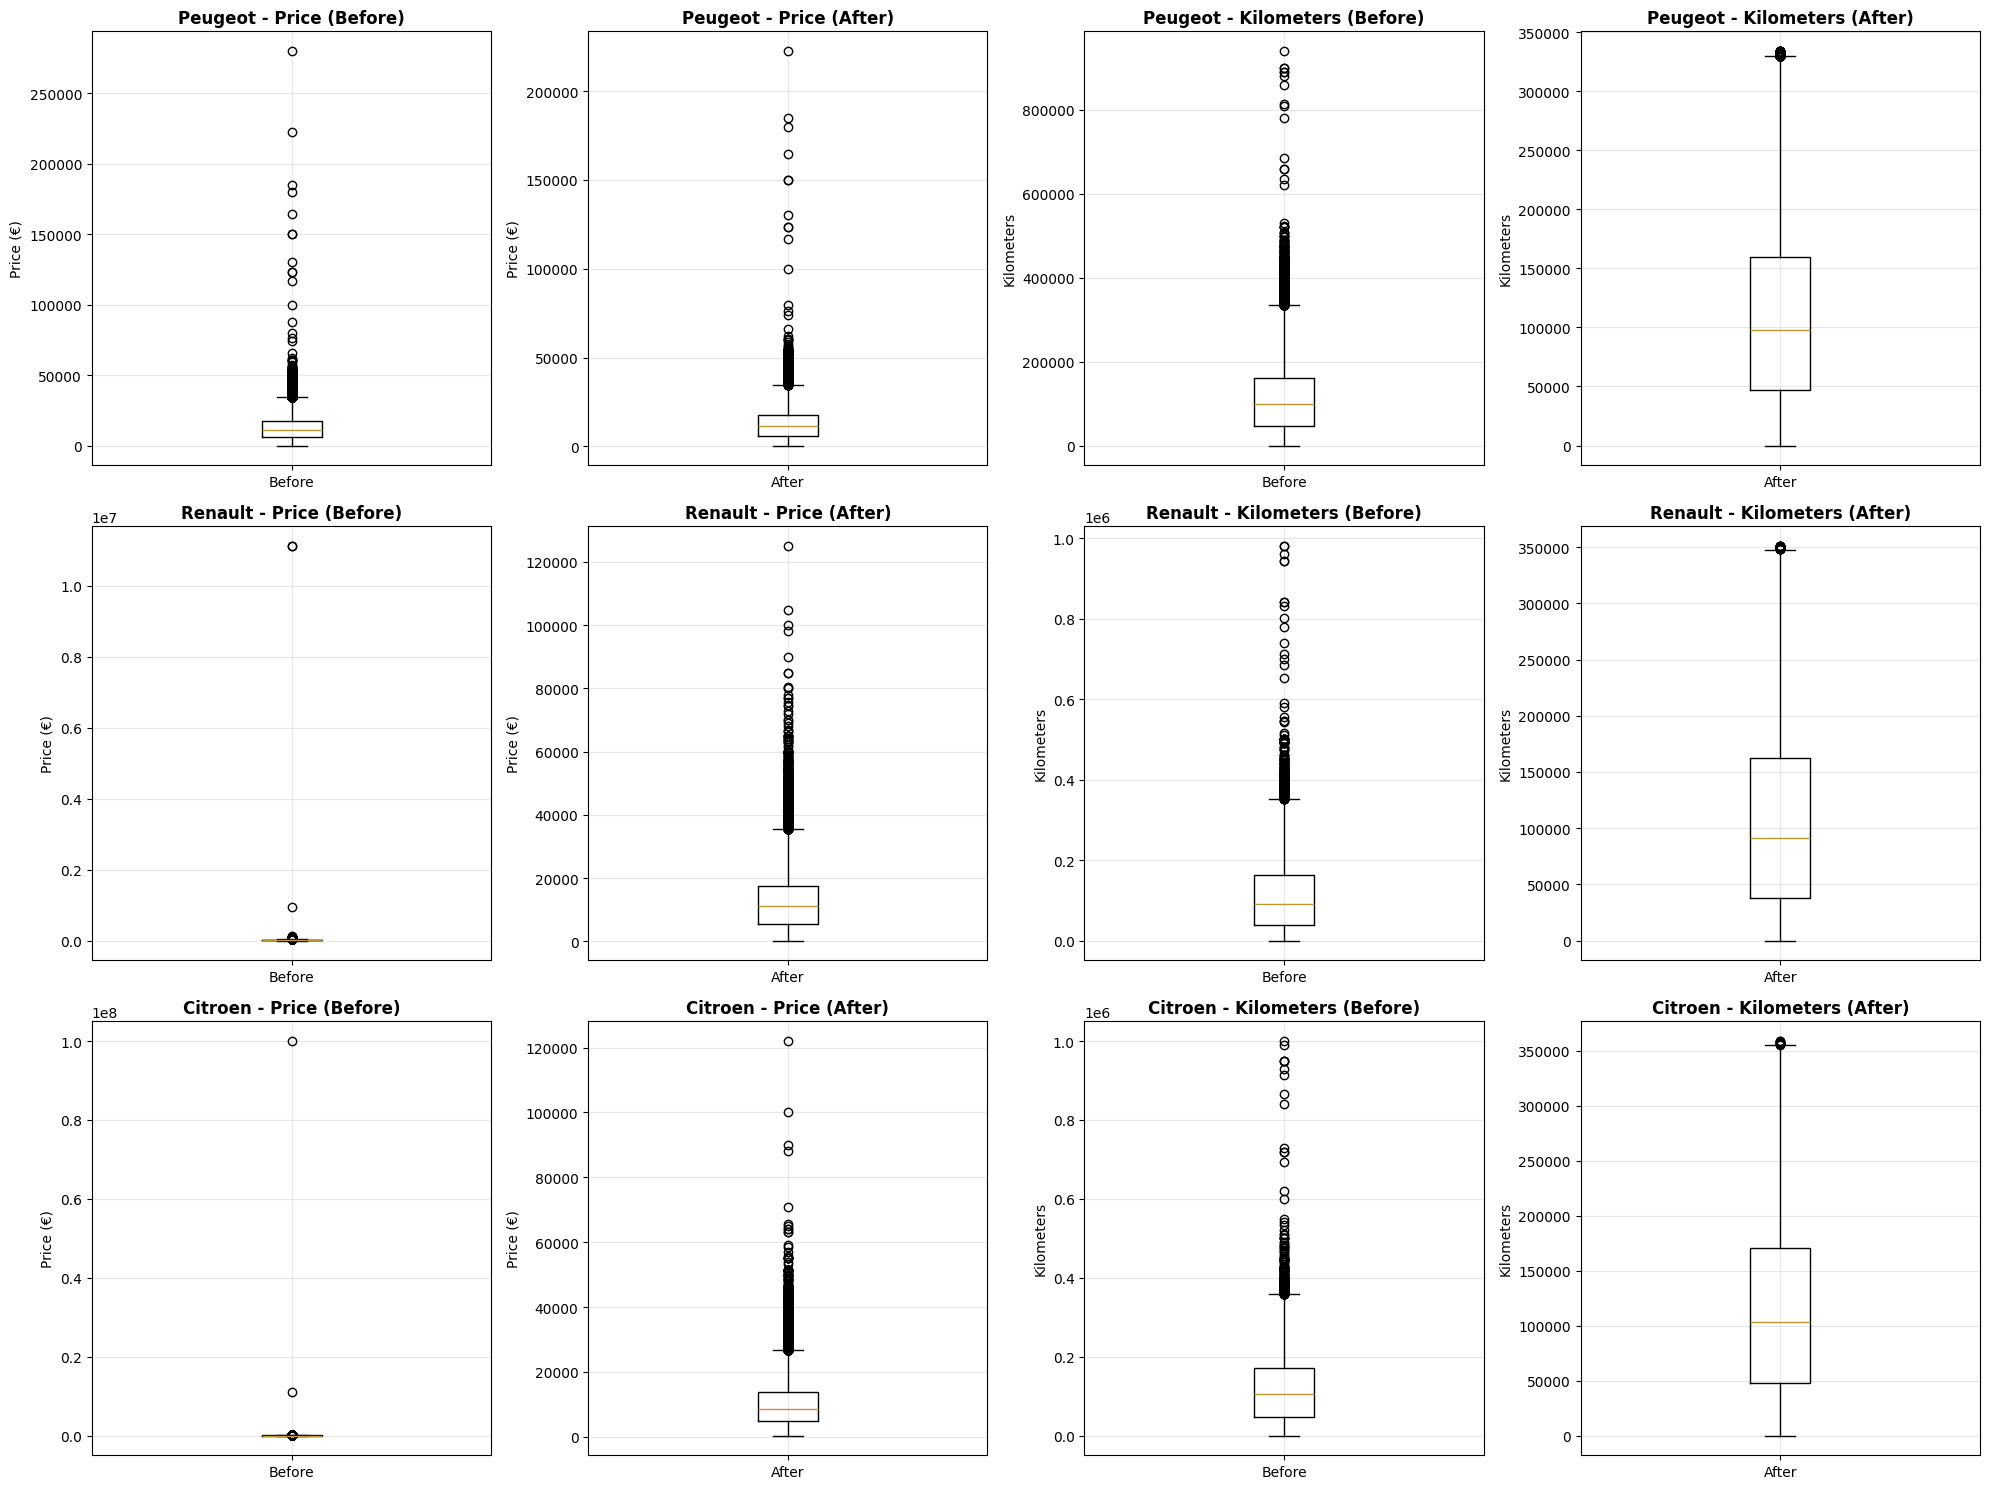

In [72]:
# Step 4.4: Create "Before and After" visualizations
print("\n4. Creating before/after visualizations...")

# Select a few example brands for visualization
example_brands = ['peugeot', 'renault', 'volkswagen', 'bmw', 'Other']
available_brands = [brand for brand in example_brands if brand in df_outliers['brand'].unique().to_list()]

if len(available_brands) >= 3:
    example_brands = available_brands[:3]  # Take first 3 available
else:
    # Fallback to top 3 brands
    top_brands = df_outliers.group_by('brand').len().sort('len', descending=True).head(3)
    example_brands = top_brands['brand'].to_list()

print(f"Creating visualizations for brands: {example_brands}")

# Create before/after comparison plots
fig, axes = plt.subplots(len(example_brands), 4, figsize=(20, 5*len(example_brands)))
if len(example_brands) == 1:
    axes = axes.reshape(1, -1)

for i, brand in enumerate(example_brands):
    # Get data for this brand
    before_data = df_outliers.filter(pl.col('brand') == brand)
    after_data = df_clean.filter(pl.col('brand') == brand)
    
    if before_data.height == 0:
        continue
        
    # Convert to pandas for easier plotting
    before_pd = before_data.to_pandas()
    after_pd = after_data.to_pandas()
    
    # Price boxplots
    axes[i, 0].boxplot([before_pd['price']], tick_labels=['Before'])
    axes[i, 0].set_title(f'{brand.capitalize()} - Price (Before)', fontweight='bold')
    axes[i, 0].set_ylabel('Price (€)')
    axes[i, 0].grid(True, alpha=0.3)
    
    axes[i, 1].boxplot([after_pd['price']], tick_labels=['After'])
    axes[i, 1].set_title(f'{brand.capitalize()} - Price (After)', fontweight='bold')
    axes[i, 1].set_ylabel('Price (€)')
    axes[i, 1].grid(True, alpha=0.3)
    
    # Kilometers boxplots
    axes[i, 2].boxplot([before_pd['km']], tick_labels=['Before'])
    axes[i, 2].set_title(f'{brand.capitalize()} - Kilometers (Before)', fontweight='bold')
    axes[i, 2].set_ylabel('Kilometers')
    axes[i, 2].grid(True, alpha=0.3)
    
    axes[i, 3].boxplot([after_pd['km']], tick_labels=['After'])
    axes[i, 3].set_title(f'{brand.capitalize()} - Kilometers (After)', fontweight='bold')
    axes[i, 3].set_ylabel('Kilometers')
    axes[i, 3].grid(True, alpha=0.3)
    
    # Print summary stats for this brand
    removed = before_data.height - after_data.height
    pct_removed = (removed / before_data.height) * 100 if before_data.height > 0 else 0
    print(f"\n{brand.capitalize()} outlier removal:")
    print(f"  Before: {before_data.height:,} cars")
    print(f"  After: {after_data.height:,} cars")
    print(f"  Removed: {removed:,} cars ({pct_removed:.1f}%)")

plt.tight_layout()
plt.show()

## Step 5: Summary and Next Steps

Summary of the comprehensive data cleaning process and recommendations for future analysis.

In [ ]:
print("📋 COMPREHENSIVE CLEANING SUMMARY")
print("=" * 60)

# Calculate final statistics
original_rows = df.height
final_rows = df_clean.height
total_removed = original_rows - final_rows
retention_rate = (final_rows / original_rows) * 100

print(f"🔢 DATA TRANSFORMATION SUMMARY:")
print(f"  Original dataset: {original_rows:,} rows")
print(f"  Final clean dataset: {final_rows:,} rows")
print(f"  Total rows removed: {total_removed:,}")
print(f"  Data retention rate: {retention_rate:.1f}%")

print(f"\n🧹 CLEANING STEPS PERFORMED:")
print(f"  ✅ 1. Data type conversion (price, year, kilometers)")
print(f"  ✅ 2. Rare brand grouping (threshold: {RARE_BRAND_THRESHOLD} listings)")
print(f"  ✅ 3. Per-brand outlier detection using log-transformed IQR")
print(f"  ✅ 4. Invalid data removal (nulls, zeros, negative values)")

# Final dataset quality check
print(f"\n📊 FINAL DATASET QUALITY:")
brands_final = df_clean['brand'].n_unique()
models_final = df_clean['model'].n_unique()

print(f"  Unique brands: {brands_final}")
print(f"  Unique models: {models_final}")
print(f"  Price range: €{df_clean['price'].min():,.0f} - €{df_clean['price'].max():,.0f}")
print(f"  Year range: {df_clean['year'].min():.0f} - {df_clean['year'].max():.0f}")
print(f"  Kilometer range: {df_clean['km'].min():,.0f} - {df_clean['km'].max():,.0f}")

# Check for remaining missing values
missing_summary = []
for col in df_clean.columns:
    missing_count = df_clean[col].null_count()[0]
    if missing_count > 0:
        missing_summary.append(f"{col}: {missing_count}")

if missing_summary:
    print(f"  ⚠️  Remaining missing values: {', '.join(missing_summary)}")
else:
    print(f"  ✅ No missing values")

print(f"\n🚀 RECOMMENDED NEXT STEPS:")
print("=" * 40)

print(f"📈 IMMEDIATE NEXT STEPS:")
print(f"  1. Save the cleaned dataset: df_clean.write_csv('cleaned_car_data.csv')")
print(f"  2. Perform exploratory data analysis on clean data")
print(f"  3. Feature engineering:")
print(f"     - Create car age from year: (2024 - year)")
print(f"     - Normalize kilometers by brand/model")
print(f"     - Create price per year features")

print(f"\n🔍 ADVANCED ANALYSIS CONSIDERATIONS:")
print(f"  • Explore more nuanced brand grouping:")
print(f"    - Group by market segment (Luxury, Economy, SUV, etc.)")
print(f"    - Consider country of origin grouping")
print(f"  • Model-level analysis for popular brands:")
print(f"    - Outlier detection within brand+model combinations")
print(f"    - Model popularity and pricing analysis")

print(f"\n🤖 MODELING PREPARATION:")
print(f"  • Encoding strategies:")
print(f"    - Target encoding for high-cardinality categorical variables")
print(f"    - Consider embeddings for brand/model combinations")
print(f"  • Feature scaling and normalization")
print(f"  • Train/validation/test split (70/15/15 recommended)")

print(f"\n✅ DATA IS NOW READY FOR MACHINE LEARNING!")
print(f"The cleaned dataset has {final_rows:,} high-quality observations")
print(f"with {retention_rate:.1f}% of original data retained after thorough cleaning.")

In [ ]:
# Save the cleaned dataset for future use
print("💾 SAVING CLEANED DATASET")
print("=" * 30)

# Save to processed data directory
cleaned_file_path = PROCESSED_DATA_PATH / "cleaned_car_data.csv"
df_clean.write_csv(cleaned_file_path)

print(f"✅ Cleaned dataset saved to: {cleaned_file_path}")
print(f"📊 File contains: {df_clean.height:,} rows × {df_clean.width} columns")
print(f"🎯 Ready for modeling and further analysis!")

# Display final sample
print(f"\n📋 FINAL CLEANED DATA SAMPLE:")
print(df_clean.head().to_pandas().to_string(index=False))